In [15]:
from pymongo import MongoClient
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.sparse import csr_matrix

# Conexión a MongoDB y generación de la matriz de interacción
client = MongoClient("mongodb://localhost:27017/")
db = client["my_database"]

# Cargar datos desde MongoDB
customers = pd.DataFrame(list(db.customers.find({}, {"Customer ID": 1, "First Name": 1, "_id": 0})))
products = pd.DataFrame(list(db.products.find({}, {"Product ID": 1, "Name": 1, "_id": 0})))
orders = pd.DataFrame(list(db.orders.find({}, {"Customer ID": 1, "Product ID": 1, "_id": 0})))

# Unir las órdenes con los nombres de clientes y productos
orders = orders.merge(customers, left_on="Customer ID", right_on="Customer ID", how="left")
orders = orders.merge(products, left_on="Product ID", right_on="Product ID", how="left")

# Crear matriz de interacción cliente-producto
interaction_matrix = orders.pivot_table(
    index="First Name",  # Nombre del cliente
    columns="Name",      # Nombre del producto
    aggfunc="size",      # Contar interacciones
    fill_value=0         # Rellenar valores ausentes con 0
)

# Convertir la matriz de interacción a formato disperso
sparse_matrix = csr_matrix(interaction_matrix)

# Entrenar modelo KNN
knn_model = NearestNeighbors(metric="cosine", algorithm="brute")
knn_model.fit(sparse_matrix)
print("Modelo KNN entrenado correctamente.")

# Función para evaluar el modelo KNN
def evaluate_knn(interaction_matrix, knn_model, k=5):
    """
    Evalúa el modelo KNN con precisión, recall y F1.
    
    Args:
        interaction_matrix (pd.DataFrame): Matriz de interacciones usuario-producto.
        knn_model: Modelo KNN entrenado.
        k (int): Número de recomendaciones a evaluar.
    
    Returns:
        dict: Métricas de evaluación (Precisión, Recall, F1).
    """
    y_true = []
    y_pred = []

    for user_index in range(interaction_matrix.shape[0]):
        # Obtener vecinos del usuario actual
        distances, indices = knn_model.kneighbors(
            interaction_matrix.iloc[user_index, :].values.reshape(1, -1), n_neighbors=k+1
        )
        
        # Excluir al propio usuario
        similar_users = indices.flatten()[1:]
        
        # Productos relevantes (verdaderos)
        relevant_products = interaction_matrix.iloc[user_index].to_numpy().nonzero()[0]
        
        # Productos recomendados (predichos)
        recommended_products = (
            interaction_matrix.iloc[similar_users]
            .sum(axis=0)
            .sort_values(ascending=False)
            .head(k)
            .index
        )
        
        # Crear listas de verdad y predicción
        y_true.extend([1 if i in relevant_products else 0 for i in range(interaction_matrix.shape[1])])
        y_pred.extend([1 if i in recommended_products else 0 for i in range(interaction_matrix.shape[1])])
    
    # Calcular métricas
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    return {"Precision": precision, "Recall": recall, "F1": f1}

# Evaluar el modelo
metrics = evaluate_knn(interaction_matrix, knn_model, k=5)
print(f"Evaluación del modelo KNN:\nPrecisión: {metrics['Precision']:.4f}\nRecall: {metrics['Recall']:.4f}\nF1: {metrics['F1']:.4f}")

# Depuración adicional para verificar resultados
print("\nDepuración:")
print(f"Tamaño de la matriz: {interaction_matrix.shape}")
print(f"Interacciones totales no nulas: {interaction_matrix.sum().sum()}")
print(f"Primeras filas de la matriz:\n{interaction_matrix.head()}")


Modelo KNN entrenado correctamente.
Evaluación del modelo KNN:
Precisión: 0.0000
Recall: 0.0000
F1: 0.0000

Depuración:
Tamaño de la matriz: (84, 466)
Interacciones totales no nulas: 500
Primeras filas de la matriz:
Name        3a AUTOCARE Car Mat Maruti Ciaz  \
First Name                                    
Alejandra                                 0   
Amanda                                    0   
Andrew                                    0   
Angela                                    0   
Angelica                                  0   

Name        3a Autocare Innova Car Mat Toyota Innova  \
First Name                                             
Alejandra                                          0   
Amanda                                             0   
Andrew                                             0   
Angela                                             0   
Angelica                                           1   

Name        3a Autocare Scorpio Car Mat Mahindra Scorpio  \
F

In [16]:
# Elegir un usuario aleatorio para probar
user_name = interaction_matrix.index[0]  # Primer usuario en la matriz
print(f"Probando recomendaciones para el usuario: {user_name}")

# Obtener los usuarios similares
user_index = interaction_matrix.index.get_loc(user_name)
distances, indices = knn_model.kneighbors(
    interaction_matrix.iloc[user_index, :].values.reshape(1, -1), n_neighbors=6
)

# Excluir al propio usuario y obtener usuarios similares
similar_users = indices.flatten()[1:]
print(f"Usuarios similares a {user_name}: {interaction_matrix.index[similar_users].tolist()}")
# Recomendar productos basados en usuarios similares
recommended_products = interaction_matrix.iloc[similar_users].sum(axis=0).sort_values(ascending=False)
recommended_products = recommended_products[interaction_matrix.loc[user_name] == 0]

# Mostrar productos recomendados
print(f"Productos recomendados para {user_name}:")
print(recommended_products.head())

# Combinar con los nombres de los productos
recommended_products_df = recommended_products.head().reset_index()
recommended_products_df.columns = ["Producto", "Relevancia"]

print(recommended_products_df)

Probando recomendaciones para el usuario: Alejandra
Usuarios similares a Alejandra: ['Stephanie', 'Michelle', 'Natasha', 'Mark', 'Lisa']
Productos recomendados para Alejandra:
Name
Jewelizer Bohemian Yellow Gold Plated Alloy Necklace         1
Lapguard Toshiba Satellite Pro A200 6 Cell Laptop Battery    1
Wallmantra Abstract Trees Wall Hanging Canvas Painting       1
Anuradha Art Silver Polished Brooch                          1
Arial Morris Women Flats                                     1
dtype: int64
                                            Producto  Relevancia
0  Jewelizer Bohemian Yellow Gold Plated Alloy Ne...           1
1  Lapguard Toshiba Satellite Pro A200 6 Cell Lap...           1
2  Wallmantra Abstract Trees Wall Hanging Canvas ...           1
3                Anuradha Art Silver Polished Brooch           1
4                           Arial Morris Women Flats           1


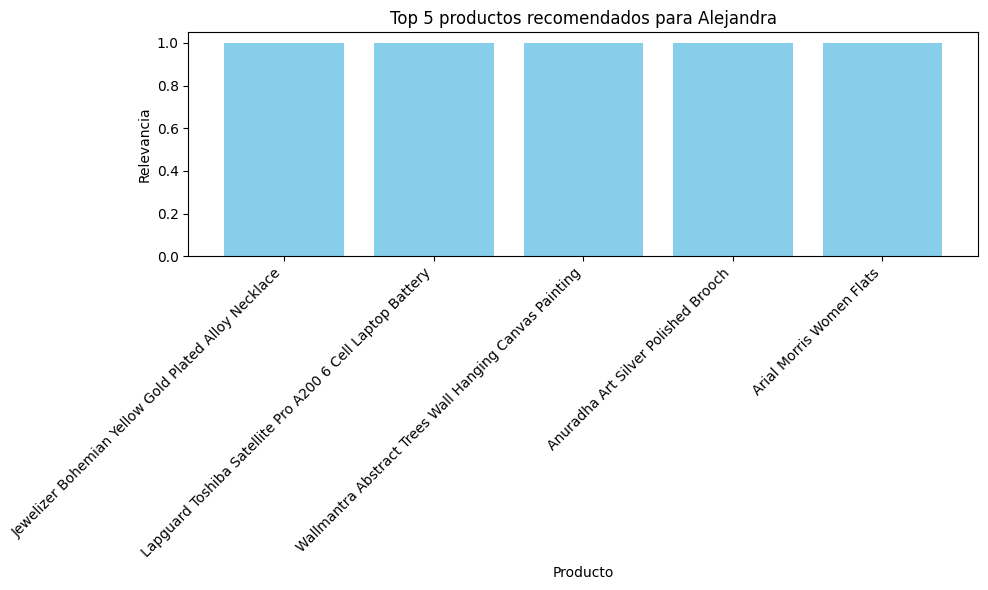

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

# Asumimos que la matriz de interacción y el modelo KNN ya están definidos
# Crear una función para obtener y graficar recomendaciones

def recommend_and_plot(user_index, interaction_matrix, knn_model, k=5):
    """
    Obtiene recomendaciones para un usuario y grafica los productos recomendados.
    
    Args:
        user_index (int): Índice del usuario en la matriz de interacción.
        interaction_matrix (pd.DataFrame): Matriz de interacciones usuario-producto.
        knn_model: Modelo KNN entrenado.
        k (int): Número de productos recomendados a mostrar.
    """
    # Obtener vecinos del usuario
    distances, indices = knn_model.kneighbors(
        interaction_matrix.iloc[user_index, :].values.reshape(1, -1), n_neighbors=k+1
    )
    similar_users = indices.flatten()[1:]  # Excluir al propio usuario

    # Sumar las interacciones de los vecinos y ordenar por relevancia
    recommended_products = (
        interaction_matrix.iloc[similar_users]
        .sum(axis=0)
        .sort_values(ascending=False)
        .head(k)
    )
    
    # Preparar el DataFrame para graficar
    recommended_products_df = pd.DataFrame({
        "Producto": recommended_products.index,
        "Relevancia": recommended_products.values
    })

    # Graficar los productos recomendados
    plt.figure(figsize=(10, 6))
    plt.bar(recommended_products_df["Producto"], recommended_products_df["Relevancia"], color='skyblue')
    plt.title(f"Top {k} productos recomendados para {interaction_matrix.index[user_index]}")
    plt.xlabel("Producto")
    plt.ylabel("Relevancia")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Seleccionar un usuario y graficar recomendaciones
user_index = 0  # Cambia este índice para probar con diferentes usuarios
recommend_and_plot(user_index, interaction_matrix, knn_model, k=5)


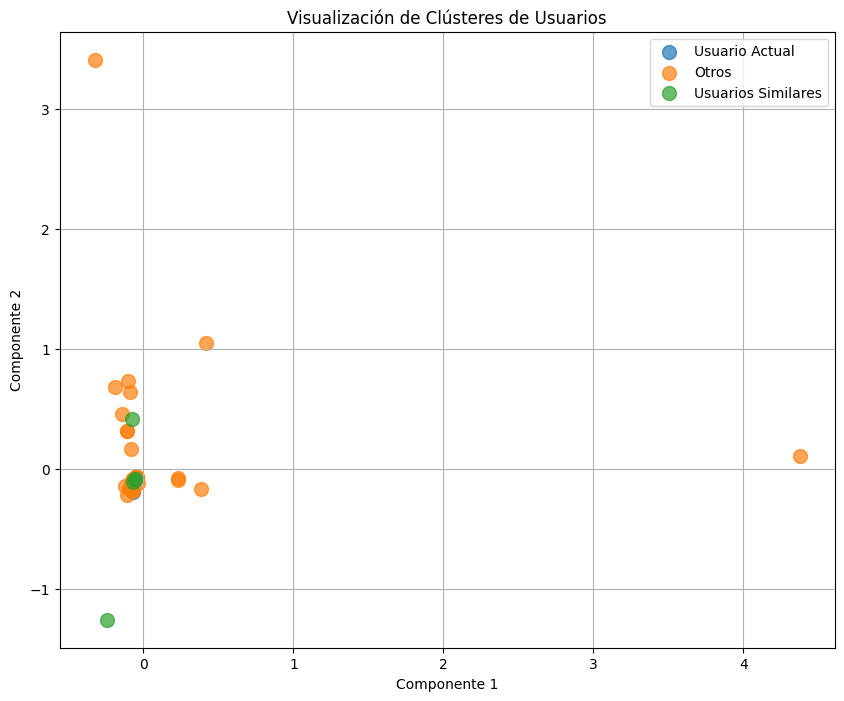

In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

def plot_all_clusters(interaction_matrix, user_name, similar_users, knn_model):
    # Reducir dimensionalidad con PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(interaction_matrix)
    
    # Crear DataFrame para los datos reducidos
    reduced_df = pd.DataFrame(reduced_data, columns=["Componente 1", "Componente 2"], index=interaction_matrix.index)
    reduced_df["Tipo"] = "Otros"
    
    # Identificar el usuario actual y similares
    reduced_df.loc[user_name, "Tipo"] = "Usuario Actual"
    reduced_df.loc[similar_users, "Tipo"] = "Usuarios Similares"
    
    # Generar los clústeres basados en el modelo KNN
    cluster_labels = []
    for i in range(len(interaction_matrix)):
        distances, indices = knn_model.kneighbors(interaction_matrix.iloc[i, :].values.reshape(1, -1), n_neighbors=6)
        cluster_labels.append(indices.flatten()[1:].tolist())
    
    # Agregar los clusters como una columna (opcional para análisis avanzado)
    reduced_df["Cluster"] = cluster_labels
    
    # Graficar todos los usuarios
    plt.figure(figsize=(10, 8))
    for tipo in reduced_df["Tipo"].unique():
        subset = reduced_df[reduced_df["Tipo"] == tipo]
        plt.scatter(subset["Componente 1"], subset["Componente 2"], label=tipo, alpha=0.7, s=100)
    
    # Personalizar gráfico
    plt.title("Visualización de Clústeres de Usuarios")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.legend()
    plt.grid(True)
    plt.show()

# Llamar a la función para graficar todos los clústeres
similar_users_names = interaction_matrix.index[similar_users].tolist()
plot_all_clusters(interaction_matrix, user_name, similar_users_names, knn_model)



Modelo KNN entrenado correctamente.
Evaluación del modelo KNN:
Precisión: 0.0000
Recall: 0.0000
F1: 0.0000


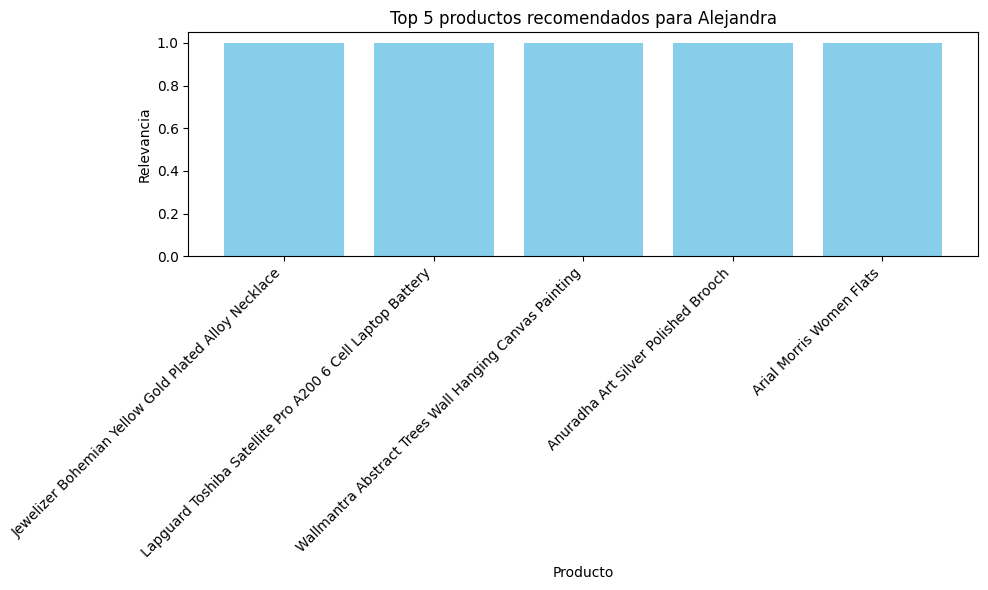

In [19]:
from pymongo import MongoClient
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

# Conexión a MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["my_database"]

# Cargar datos desde MongoDB
customers = pd.DataFrame(list(db.customers.find({}, {"Customer ID": 1, "First Name": 1, "_id": 0})))
products = pd.DataFrame(list(db.products.find({}, {"Product ID": 1, "Name": 1, "_id": 0})))
orders = pd.DataFrame(list(db.orders.find({}, {"Customer ID": 1, "Product ID": 1, "_id": 0})))

# Validar que las colecciones no estén vacías
if customers.empty or products.empty or orders.empty:
    raise ValueError("Las colecciones de clientes, productos u órdenes están vacías.")

# Unir las órdenes con los nombres de clientes y productos
orders = orders.merge(customers, left_on="Customer ID", right_on="Customer ID", how="left")
orders = orders.merge(products, left_on="Product ID", right_on="Product ID", how="left")

# Crear matriz de interacción cliente-producto
interaction_matrix = orders.pivot_table(
    index="First Name",  # Nombre del cliente
    columns="Name",      # Nombre del producto
    aggfunc="size",      # Contar interacciones
    fill_value=0         # Rellenar valores ausentes con 0
)

# Convertir la matriz de interacción a formato disperso
sparse_matrix = csr_matrix(interaction_matrix)

# Entrenar modelo KNN
knn_model = NearestNeighbors(metric="cosine", algorithm="brute")
knn_model.fit(sparse_matrix)
print("Modelo KNN entrenado correctamente.")

# Función para evaluar el modelo KNN
def evaluate_knn(interaction_matrix, knn_model, k=5):
    """
    Evalúa el modelo KNN con precisión, recall y F1.
    
    Args:
        interaction_matrix (pd.DataFrame): Matriz de interacciones usuario-producto.
        knn_model: Modelo KNN entrenado.
        k (int): Número de recomendaciones a evaluar.
    
    Returns:
        dict: Métricas de evaluación (Precisión, Recall, F1).
    """
    y_true = []
    y_pred = []

    for user_index in range(interaction_matrix.shape[0]):
        # Obtener vecinos del usuario actual
        distances, indices = knn_model.kneighbors(
            interaction_matrix.iloc[user_index, :].values.reshape(1, -1), n_neighbors=k+1
        )
        
        # Excluir al propio usuario
        similar_users = indices.flatten()[1:]
        
        # Productos relevantes (verdaderos)
        relevant_products = interaction_matrix.iloc[user_index].to_numpy().nonzero()[0]
        
        # Productos recomendados (predichos)
        recommended_products = (
            interaction_matrix.iloc[similar_users]
            .sum(axis=0)
            .sort_values(ascending=False)
            .head(k)
            .index
        )
        
        # Crear listas de verdad y predicción
        y_true.extend([1 if i in relevant_products else 0 for i in range(interaction_matrix.shape[1])])
        y_pred.extend([1 if i in recommended_products else 0 for i in range(interaction_matrix.shape[1])])
    
    # Calcular métricas
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    return {"Precision": precision, "Recall": recall, "F1": f1}

# Evaluar el modelo
metrics = evaluate_knn(interaction_matrix, knn_model, k=5)
print(f"Evaluación del modelo KNN:\nPrecisión: {metrics['Precision']:.4f}\nRecall: {metrics['Recall']:.4f}\nF1: {metrics['F1']:.4f}")

# Función para recomendar productos y graficar
def recommend_and_plot(user_index, interaction_matrix, knn_model, k=5):
    """
    Obtiene recomendaciones para un usuario y grafica los productos recomendados.
    
    Args:
        user_index (int): Índice del usuario en la matriz de interacción.
        interaction_matrix (pd.DataFrame): Matriz de interacciones usuario-producto.
        knn_model: Modelo KNN entrenado.
        k (int): Número de productos recomendados a mostrar.
    """
    # Obtener vecinos del usuario
    distances, indices = knn_model.kneighbors(
        interaction_matrix.iloc[user_index, :].values.reshape(1, -1), n_neighbors=k+1
    )
    similar_users = indices.flatten()[1:]  # Excluir al propio usuario

    # Sumar las interacciones de los vecinos y ordenar por relevancia
    recommended_products = (
        interaction_matrix.iloc[similar_users]
        .sum(axis=0)
        .sort_values(ascending=False)
        .head(k)
    )
    
    # Preparar el DataFrame para graficar
    recommended_products_df = pd.DataFrame({
        "Producto": recommended_products.index,
        "Relevancia": recommended_products.values
    })

    # Graficar los productos recomendados
    plt.figure(figsize=(10, 6))
    plt.bar(recommended_products_df["Producto"], recommended_products_df["Relevancia"], color='skyblue')
    plt.title(f"Top {k} productos recomendados para {interaction_matrix.index[user_index]}")
    plt.xlabel("Producto")
    plt.ylabel("Relevancia")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Seleccionar un usuario y graficar recomendaciones
user_index = 0  # Cambia este índice para probar con diferentes usuarios
recommend_and_plot(user_index, interaction_matrix, knn_model, k=5)
